In [1]:
import sys
pdefind_path = "/Users/pongpisit/Desktop/research/PDE-FIND/"
sys.path.insert(0, pdefind_path)
from misc import h5file, pickle_load
from PDE_FIND import print_pde
from itertools import combinations

import os
from os.path import join as pjoin
from pathlib import Path
import yaml

import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt
import dedalus.public as d3
import sympy
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import curve_fit
from jaxfit import CurveFit
from levenberg_marquardt import lm as lm_curve_fit
from functools import partial

sys.path.insert(0, "/Users/pongpisit/Desktop/research/parametric-discovery/")
from best_subset import brute_force, brute_force_all_subsets

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    nobs2 = nobs / 2.0
    ssr = np.sum(np.abs(ground - prediction)**2)
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

import re
from collections import Counter

def ef(c):
    if c > 1: return f"dx({ef(c-1)})"
    else: return "dx(u)"
    
def convert2dedalus(input_string):
    old_strings = set(re.findall(r"u_\d+", input_string))
    new_strings = [ef(s.count('1')) for s in old_strings]
    for o, n in zip(old_strings, new_strings):
        input_string = input_string.replace(o, n)
    return input_string

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.


In [2]:
noise_lv = 30

fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"

fp1 = "../../UBIC-play/Simulation/IPI_output_files/Burgers_shock/PMS_data.h5"
fp2 = "../../UBIC-play/Simulation/IPI_output_files/Burgers/encoded_pde_names.yaml"

dataset = loadmat('../../UBIC-play/Datasets/burgers_shock.mat')
x_org = dataset['x'][:, 0]; print(x_org)
t_org = dataset['t'][:, 0]; print(t_org)
u_clean = dataset['usol']

X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)

with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]

[-1.         -0.99215686 -0.98431373 -0.97647059 -0.96862745 -0.96078431
 -0.95294118 -0.94509804 -0.9372549  -0.92941176 -0.92156863 -0.91372549
 -0.90588235 -0.89803922 -0.89019608 -0.88235294 -0.8745098  -0.86666667
 -0.85882353 -0.85098039 -0.84313725 -0.83529412 -0.82745098 -0.81960784
 -0.81176471 -0.80392157 -0.79607843 -0.78823529 -0.78039216 -0.77254902
 -0.76470588 -0.75686275 -0.74901961 -0.74117647 -0.73333333 -0.7254902
 -0.71764706 -0.70980392 -0.70196078 -0.69411765 -0.68627451 -0.67843137
 -0.67058824 -0.6627451  -0.65490196 -0.64705882 -0.63921569 -0.63137255
 -0.62352941 -0.61568627 -0.60784314 -0.6        -0.59215686 -0.58431373
 -0.57647059 -0.56862745 -0.56078431 -0.55294118 -0.54509804 -0.5372549
 -0.52941176 -0.52156863 -0.51372549 -0.50588235 -0.49803922 -0.49019608
 -0.48235294 -0.4745098  -0.46666667 -0.45882353 -0.45098039 -0.44313725
 -0.43529412 -0.42745098 -0.41960784 -0.41176471 -0.40392157 -0.39607843
 -0.38823529 -0.38039216 -0.37254902 -0.36470588 -0.3

In [3]:
complexity = 2
all_subsets = list(combinations(range(len(config["encoded_feature_names"])), complexity))
scores = []
for s in all_subsets:
    inp = X_pre[:, s]
    w = np.linalg.lstsq(inp, y_pre, rcond=None)[0]
    scores.append(((y_pre-inp@w)**2).mean())
    
init_params = np.linalg.lstsq(X_pre[:, all_subsets[np.argmin(scores)]], 
                              y_pre, rcond=None)[0].flatten().astype(np.float64)

effective_terms = [convert2dedalus(config["encoded_feature_names"][i]) 
                   for i in all_subsets[np.argmin(scores)]]
# print(all_subsets[np.argmin(scores)])
print(effective_terms)
print(init_params)

['dx(dx(u))', 'u*dx(u)']
[ 0.00374609 -0.92514145]


In [4]:
use_CWF = True
if use_CWF:
    print("Using CWF")
    cws_IPI_data = loadmat("../WSINDy_PDE_latest/outputs/burgers_shock/burgers_shock_noise30_ksvdreg_outputs.mat")
    cws_W = cws_IPI_data['W']
    cws_W = cws_W[abs(cws_W)>0]

    rhs_desc = np.array([e.tolist() for e in cws_IPI_data['tags_pde_G'][0]])
    rhs_desc = rhs_desc[1:].flatten()
    X_cws = cws_IPI_data['oG'][:, 1:]
    y_cws = cws_IPI_data['b']
    cws_W = brute_force(X_cws, y_cws, complexity)
    print_pde(cws_W, rhs_desc)
else:
    print("Using WF")

Using CWF
u_t = (0.002885 +0.000000i)u^{1}_{xx}
    + (-0.447073 +0.000000i)u^{2}_{x}
   


In [5]:
def initial_function(x, a):
    return -np.sin(a*x)

def jax_initial_function(x, a):
    return -jnp.sin(a*x)

recovered_params = np.array(CurveFit().curve_fit(jax_initial_function, x_org.flatten(), un[:, 0], 
                                                  p0=[3.1763942])[0])

initial_condition_function = partial(initial_function, a=3.1763942)

recovered_params

2024-01-08 20:25:09,248 jax._src.dispatch 0/1 WARNING :: Finished tracing + transforming jit(convert_element_type) in 0.00032901763916015625 sec
2024-01-08 20:25:09,256 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-01-08 20:25:09,256 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-01-08 20:25:09,257 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-01-08 20:25:09,258 jax._src.xla_bridge 0/1 INFO :: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-01-08 20:25:09,260 jax._src.dispatch 0/1 WARNING :: Finished tracing + transforming jit

array([3.17640295])

In [6]:
# Parameters
Lx = 1
spatial_domain = -Lx, Lx+(x_org[1]-x_org[0])
Nx = 256
dealias = 1.5 # 3/2
stop_sim_time = 0.99 # stop_sim_time * fac -> timestep / fac
timestepper = d3.SBDF4
acc = 4
timestep = (4e-4)/acc
spatial_variable_name = 'x'
target_variable_name = 'u'
dtype = np.float64

In [7]:
# Bases
xcoord = d3.Coordinate(spatial_variable_name)
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=spatial_domain, dealias=dealias)
# Fields
u = dist.Field(name=target_variable_name, bases=xbasis)
# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

In [8]:
# Problem\
problem = d3.IVP([u], namespace=locals())
if not use_CWF:
    if complexity == 2:
        a, b = np.abs(init_params)
        problem.add_equation("dt(u)-a*dx(dx(u))=-b*u*dx(u)")
    elif complexity == 3:
        a, b, c = np.abs(init_params)
        problem.add_equation("dt(u)-a*u=-b*u*dx(u)+c*u*u*dx(dx(u))")
else:
    if complexity == 2:
        print_pde(cws_W, rhs_desc)
        a, b = np.abs(cws_W[np.abs(cws_W)>0])
        print(a,b)
        problem.add_equation("dt(u)-a*dx(dx(u))=-b*dx(u**2)")
    elif complexity == 3:
        print_pde(cws_W, rhs_desc)
        a, b, c = np.abs(cws_W[np.abs(cws_W)>0])
        print(a,b,c)
        problem.add_equation("dt(u)+a*u-b*dx(dx(u))=-c*dx(u**2)")

# Initial conditions
x = dist.local_grid(xbasis)
u['g'] = initial_condition_function(x)
# u['g'] = un[:, 0]

u_t = (0.002885 +0.000000i)u^{1}_{xx}
    + (-0.447073 +0.000000i)u^{2}_{x}
   
0.0028848263216393094 0.4470726825183966


In [9]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % (25*acc) == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
spatial_var = x.ravel()
temporal_var = np.array(t_list).ravel()
simulated_var = np.array(u_list)

2024-01-08 20:25:09,699 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s
2024-01-08 20:25:12,785 solvers 0/1 INFO :: Simulation stop time reached.


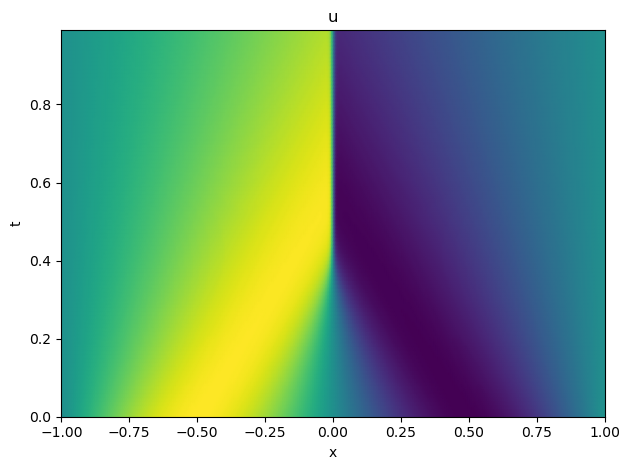

In [10]:
# Plot
plt.figure()
plt.pcolormesh(spatial_var, temporal_var, simulated_var, shading='gouraud')
plt.xlim(x.min(), x.max())
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('u')
plt.tight_layout()
plt.show()

In [11]:
### WF ###
# (2, (-67174.49732561453, -67190.79802087546))
# (3, (-36773.75680576297, -36798.20784865437))
### CWF ###
# (2, (-64887.848565877, -64904.149261137936))
# (3, (-64282.29925775754, -64306.75030064894))
dedalus_sim_sol = simulated_var.T
complexity, BIC_AIC(dedalus_sim_sol.reshape(-1, 1), un.reshape(-1, 1), complexity)

(2, (-64887.848565876244, -64904.14926113718))

In [12]:
np.linalg.norm(u_clean-dedalus_sim_sol, 'fro'), np.linalg.norm(u_clean-dedalus_sim_sol, np.inf)

(4.229565625336653, 5.251522589832472)

In [13]:
print("WF")
reproduced_data = loadmat("../DeepHPMs/Matlab/Burgers_shock_sim/burgers_shock_sim_com2.mat")
print(np.linalg.norm(u_clean-reproduced_data['usol'], 'fro'), np.linalg.norm(u_clean-reproduced_data['usol'], np.inf))
print()
print("CWF")
reproduced_data = loadmat("../DeepHPMs/Matlab/Burgers_shock_sim/burgers_shock_sim_CWF_com2.mat")
print(2, BIC_AIC(reproduced_data["usol"].reshape(-1, 1), un.reshape(-1, 1), 2))
print(np.linalg.norm(u_clean-reproduced_data['usol'], 'fro'), np.linalg.norm(u_clean-reproduced_data['usol'], np.inf))
reproduced_data = loadmat("../DeepHPMs/Matlab/Burgers_shock_sim/burgers_shock_sim_CWF_com3.mat")
print(3, BIC_AIC(reproduced_data["usol"].reshape(-1, 1), un.reshape(-1, 1), 3))
print(np.linalg.norm(u_clean-reproduced_data['usol'], 'fro'), np.linalg.norm(u_clean-reproduced_data['usol'], np.inf))

WF
3.09236216730776 5.946297383167179

CWF
2 (-64900.024708155244, -64916.32540341618)
4.234072747999031 5.490743854393083
3 (-64299.300092846206, -64323.751135737606)
4.979243656449399 7.262812945737686


In [14]:
reproduced_data = loadmat("../DeepHPMs/Matlab/Burgers_shock_sim/burgers_shock_reproduce.mat")
np.linalg.norm(u_clean-reproduced_data['usol'], 'fro'), np.linalg.norm(u_clean-reproduced_data['usol'], np.inf)

(0.282472265575252, 0.9418639411946279)

In [15]:
### WF ###
# Dedalus: 3.08782 5.80897
# Chebfun: 3.09236 5.94630
### CWF ###
# Dedalus: (4.229565625336504, 5.2515225898322)
# Chebfun: (4.234072747999031 5.490743854393083)

In [16]:
# np.save(f"burgers_shock_dedalus_sim_com{complexity}.npy", dedalus_sim_sol)